In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv('labels.csv')
print(f"Total children: {len(df)}")
df.head()

Total children: 512


,child_id,gender,height in cm,weight in grams,head circumference in cm,waistline in cm,age in months
0,child0001,f,100.0,15000,51.0,53,42
1,child0002,f,118.0,28400,52.5,66,78
2,child0003,m,95.7,19000,50.0,52,33
3,child0004,m,109.5,21400,52.0,62,53
4,child0005,m,93.5,12100,50.0,49,36


In [3]:
# Load WHO reference tables
wfl_boys = pd.read_excel('WHO Table/wfl_boys_0-to-2-years_zscores (1).xlsx')
wfh_boys = pd.read_excel('WHO Table/wfh_boys_2-to-5-years_zscores (1).xlsx')
wfl_girls = pd.read_excel('WHO Table/tab_wfl_girls_p_0_2.xlsx')
wfh_girls = pd.read_excel('WHO Table/wfh_girls_2-to-5-years_zscores (1).xlsx')

In [5]:
# Classify nutrition status
def get_nutrition_status(row):
    height_cm = row['height in cm']
    weight_kg = row['weight in grams'] / 1000
    age_months = row['age in months']
    gender = row['gender']
    
    if age_months <= 24:
        ref_table = wfl_boys if gender == 'm' else wfl_girls
    else:
        ref_table = wfh_boys if gender == 'm' else wfh_girls
    
    if ref_table.empty:
        return 'Unknown'
    
    height_col = 'Length' if 'Length' in ref_table.columns else 'Height'
    height_idx = (ref_table[height_col] - height_cm).abs().idxmin()
    height_match = ref_table.loc[height_idx]
    
    sd3neg_col = 'SD3neg' if 'SD3neg' in ref_table.columns else ('P01' if 'P01' in ref_table.columns else 'P1')
    sd2neg_col = 'SD2neg' if 'SD2neg' in ref_table.columns else ('P3' if 'P3' in ref_table.columns else 'P5')
    sd3neg = height_match[sd3neg_col]
    sd2neg = height_match[sd2neg_col]
    
    if weight_kg < sd3neg:
        return 'SAM'
    elif weight_kg < sd2neg:
        return 'MAM'
    else:
        return 'Healthy'

df['nutrition_status'] = df.apply(get_nutrition_status, axis=1)
df_6_59 = df[(df['age in months'] >= 6) & (df['age in months'] <= 59)]

In [6]:
# Distribution summary
print("\n=== ALL 512 CHILDREN ===")
print(df['nutrition_status'].value_counts())
print(f"\nPercentages:")
print(df['nutrition_status'].value_counts(normalize=True) * 100)

print("\n=== CHILDREN 6-59 MONTHS ===")
print(f"Total: {len(df_6_59)}")
print(df_6_59['nutrition_status'].value_counts())
print(f"\nPercentages:")
print(df_6_59['nutrition_status'].value_counts(normalize=True) * 100)


=== ALL 512 CHILDREN ===
nutrition_status
Healthy    481
MAM         24
SAM          7
Name: count, dtype: int64

Percentages:
nutrition_status
Healthy    93.945312
MAM         4.687500
SAM         1.367188
Name: proportion, dtype: float64

=== CHILDREN 6-59 MONTHS ===
Total: 184
nutrition_status
Healthy    173
MAM          7
SAM          4
Name: count, dtype: int64

Percentages:
nutrition_status
Healthy    94.021739
MAM         3.804348
SAM         2.173913
Name: proportion, dtype: float64


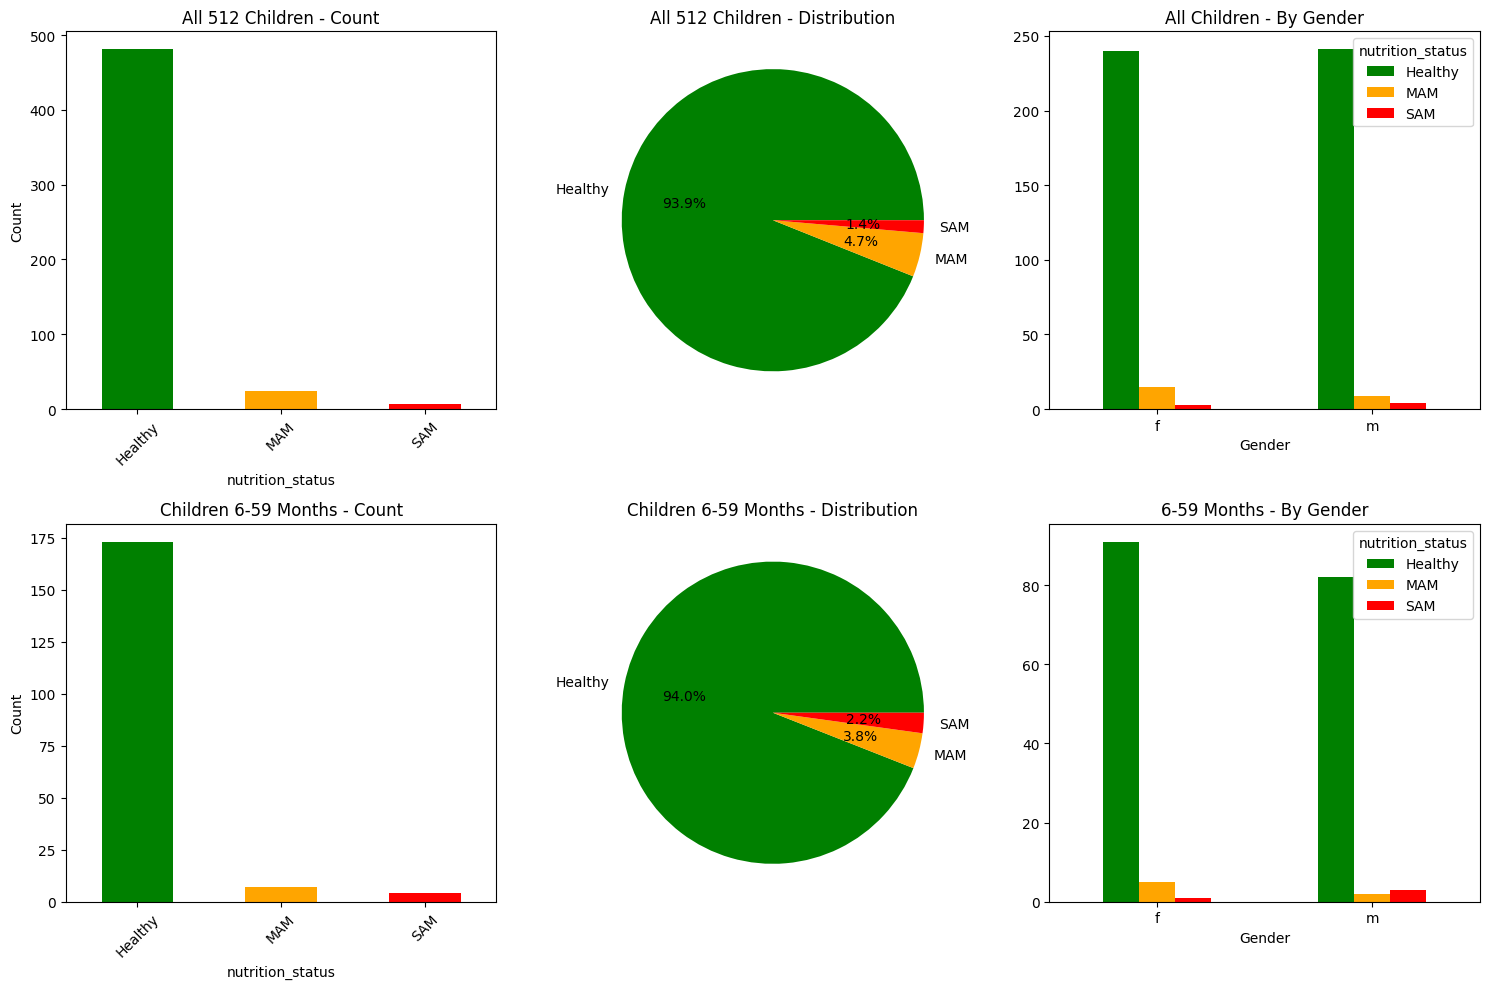

In [7]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# All children - bar chart
df['nutrition_status'].value_counts().plot(kind='bar', ax=axes[0,0], color=['green', 'orange', 'red', 'gray'])
axes[0,0].set_title('All 512 Children - Count')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# All children - pie chart
df['nutrition_status'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', colors=['green', 'orange', 'red', 'gray'])
axes[0,1].set_title('All 512 Children - Distribution')
axes[0,1].set_ylabel('')

# All children - by gender
pd.crosstab(df['gender'], df['nutrition_status']).plot(kind='bar', ax=axes[0,2], color=['green', 'orange', 'red', 'gray'])
axes[0,2].set_title('All Children - By Gender')
axes[0,2].set_xlabel('Gender')
axes[0,2].tick_params(axis='x', rotation=0)

# 6-59 months - bar chart
df_6_59['nutrition_status'].value_counts().plot(kind='bar', ax=axes[1,0], color=['green', 'orange', 'red', 'gray'])
axes[1,0].set_title('Children 6-59 Months - Count')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# 6-59 months - pie chart
df_6_59['nutrition_status'].value_counts().plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['green', 'orange', 'red', 'gray'])
axes[1,1].set_title('Children 6-59 Months - Distribution')
axes[1,1].set_ylabel('')

# 6-59 months - by gender
pd.crosstab(df_6_59['gender'], df_6_59['nutrition_status']).plot(kind='bar', ax=axes[1,2], color=['green', 'orange', 'red', 'gray'])
axes[1,2].set_title('6-59 Months - By Gender')
axes[1,2].set_xlabel('Gender')
axes[1,2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('nutrition_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

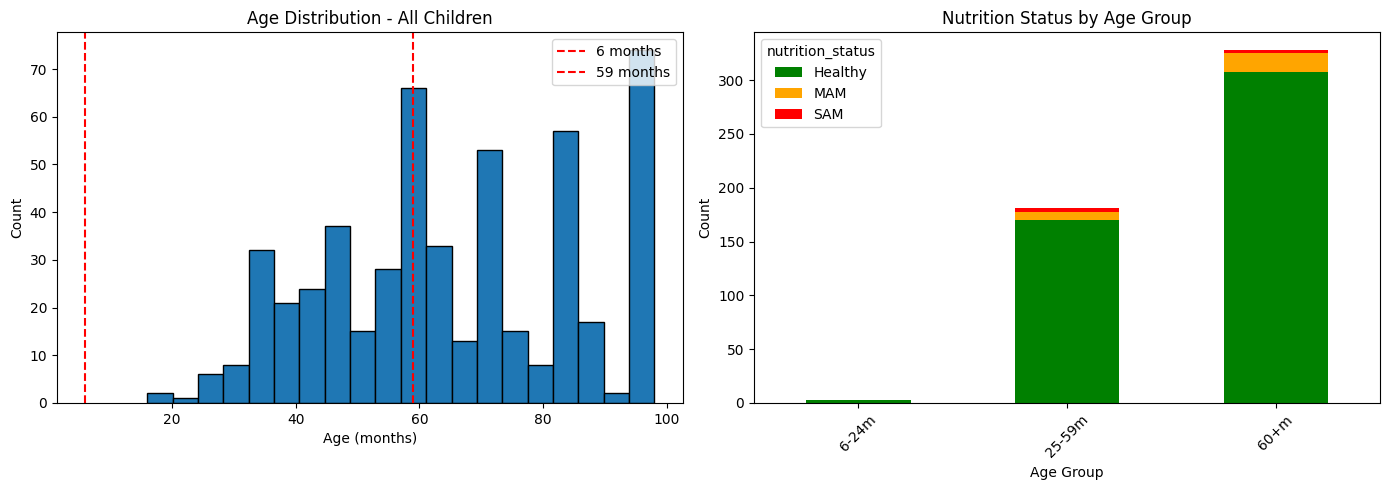

In [8]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All children age distribution
axes[0].hist(df['age in months'], bins=20, edgecolor='black')
axes[0].axvline(6, color='red', linestyle='--', label='6 months')
axes[0].axvline(59, color='red', linestyle='--', label='59 months')
axes[0].set_title('Age Distribution - All Children')
axes[0].set_xlabel('Age (months)')
axes[0].set_ylabel('Count')
axes[0].legend()

# Nutrition status by age group
age_bins = [0, 6, 24, 59, 100]
age_labels = ['0-5m', '6-24m', '25-59m', '60+m']
df['age_group'] = pd.cut(df['age in months'], bins=age_bins, labels=age_labels)
pd.crosstab(df['age_group'], df['nutrition_status']).plot(kind='bar', ax=axes[1], stacked=True, color=['green', 'orange', 'red', 'gray'])
axes[1].set_title('Nutrition Status by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('age_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Children 6-59 months: total and nutrition status distribution
total_6_59 = len(df_6_59)
status_counts = df_6_59['nutrition_status'].value_counts()
status_percent = status_counts / total_6_59 * 100

print(f"Total children (6-59 months): {total_6_59}")
print("\nDistribution by nutrition status (counts):")
print(status_counts)

print("\nDistribution by nutrition status (percentages):")
print(status_percent.round(2))

Total children (6-59 months): 184

Distribution by nutrition status (counts):
nutrition_status
Healthy    173
MAM          7
SAM          4
Name: count, dtype: int64

Distribution by nutrition status (percentages):
nutrition_status
Healthy    94.02
MAM         3.80
SAM         2.17
Name: count, dtype: float64


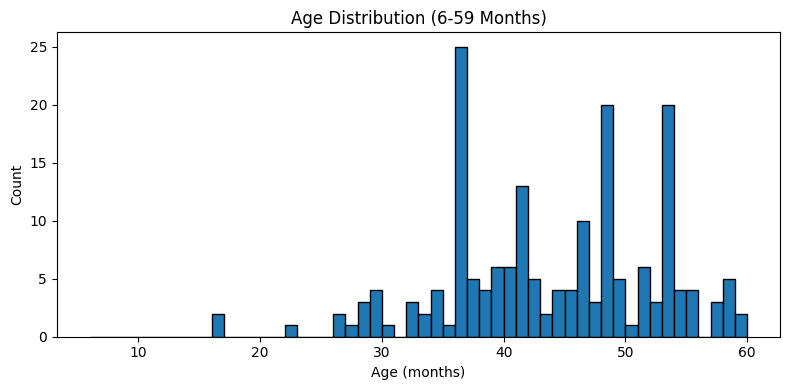

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(df_6_59['age in months'], bins=range(6, 61), edgecolor='black')
plt.title('Age Distribution (6-59 Months)')
plt.xlabel('Age (months)')

plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [9]:
# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"\nAge range: {df['age in months'].min()} - {df['age in months'].max()} months")
print(f"Children outside 6-59 months: {len(df) - len(df_6_59)}")
print(f"\nGender distribution:")
print(df['gender'].value_counts())


=== SUMMARY STATISTICS ===

Age range: 16 - 98 months
Children outside 6-59 months: 328

Gender distribution:
gender
f    258
m    254
Name: count, dtype: int64
